# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [252]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable as stb

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

import pylab as py

In [253]:
df_bike = pd.read_csv("./EDA__parte_3.csv", index_col=0)
df_bike.sample(6)

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
79,401,1676,2077,1,0,3,21,0,1,1,2,17.6,medium,3,73.7,high,4,19.348461,medium,2
193,748,3594,4342,3,0,7,13,0,3,1,1,30.6,very_high,5,63.2,high,4,9.790911,low,1
570,1383,6790,8173,3,1,7,25,0,3,1,1,29.7,very_high,5,45.0,medium,3,11.041600,low,1
585,1196,6090,7286,3,1,8,9,0,4,1,1,31.0,very_high,5,62.0,high,4,10.458700,low,1
511,3283,3308,6591,2,1,5,27,0,0,0,1,28.3,high,4,69.7,high,4,14.416457,low,1
346,155,3368,3523,4,0,12,13,0,2,1,1,11.6,low,2,59.0,high,4,9.416850,low,1


---------

# <font color = orange> REGRESIÓN LINEAL MULTIPLE

### Este DF por ahora debe contener nuestra variable respuesta y todas las variables predictivas.

- Vamos a ver la variable respuesta grafico y comprobar la normalidad = 'cnt'
- Vamos a ver graficos de variables predictivas
- Correlacion
- Covarianza
- Vamos a ver si cumplen las asunciones para hacer Anova



###  <font color = yellow> Opcion 

cnt + encoding + estandarizado minmax

    Este dataframe tiene variable respuesta, y las predictoras encoding como tipo objets y numericas que sin encoding.

In [254]:
df= df_bike.copy() # Voy a hacer una copia para no perder los datos por si necesita hacer OPCION 1

In [255]:
df.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,hum,hum_interval,hum_interval_ord,windspeed,wind_interval,wind_num_encoding
0,331,654,985,1,0,1,1,0,6,0,2,14.1,low,2,80.6,very_high,5,10.749882,low,1
1,131,670,801,1,0,1,2,0,0,0,2,14.9,low,2,69.6,high,4,16.652113,medium,2
2,120,1229,1349,1,0,1,3,0,1,1,1,8.1,very_low,1,43.7,medium,3,16.636703,medium,2
3,108,1454,1562,2,0,1,4,0,2,1,1,8.2,very_low,1,59.0,high,4,10.739832,low,1
4,82,1518,1600,2,0,1,5,0,3,1,1,9.3,low,2,43.7,medium,3,12.522300,low,1


In [256]:
df.drop(['temp_interval', 'temp_interval_ord','hum_interval','hum_interval_ord', 'wind_interval', 'wind_num_encoding'],axis=1, inplace=True)
    

In [257]:
df.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,331,654,985,1,0,1,1,0,6,0,2,14.1,80.6,10.749882
1,131,670,801,1,0,1,2,0,0,0,2,14.9,69.6,16.652113
2,120,1229,1349,1,0,1,3,0,1,1,1,8.1,43.7,16.636703
3,108,1454,1562,2,0,1,4,0,2,1,1,8.2,59.0,10.739832
4,82,1518,1600,2,0,1,5,0,3,1,1,9.3,43.7,12.522300


In [258]:
df.info() #Correcto tenemos que volver a cambiar el tipo de cada columna 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   casual           730 non-null    int64  
 1   registered       730 non-null    int64  
 2   cnt              730 non-null    int64  
 3   season_encoding  730 non-null    int64  
 4   yr               730 non-null    int64  
 5   mnth             730 non-null    int64  
 6   day              730 non-null    int64  
 7   holiday          730 non-null    int64  
 8   weekday          730 non-null    int64  
 9   workingday       730 non-null    int64  
 10  weathersit       730 non-null    int64  
 11  temp             730 non-null    float64
 12  hum              730 non-null    float64
 13  windspeed        730 non-null    float64
dtypes: float64(3), int64(11)
memory usage: 85.5 KB


In [259]:
df.columns

Index(['casual', 'registered', 'cnt', 'season_encoding', 'yr', 'mnth', 'day',
       'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum',
       'windspeed'],
      dtype='object')

    Se ha cambiado las que tienen encoding a "category"

In [260]:
df['season_encoding'] = df['season_encoding'].astype('category')  
df['yr'] = df['yr'].astype('category')  
df['mnth'] = df['mnth'].astype('category')  
df['day'] = df['day'].astype('category')  
df['holiday'] = df['holiday'].astype('category')  
df['weekday'] = df['weekday'].astype('category')  
df['workingday'] = df['workingday'].astype('category')  
df['weathersit'] = df['weathersit'].astype('category')  

### Variable respuesta - NORMALIDAD - SHAPIRO

    Nuestra variable respuesta es 'cnt', queremos ver cuantas reservas general según las variables predictoras.
    Parece que tenemos una distribución normal de nuestros datos.


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)


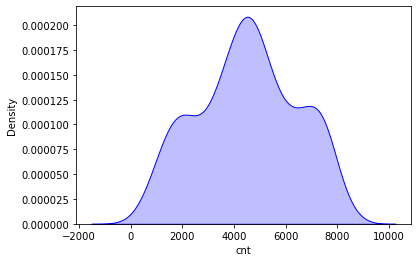

In [261]:
sns.distplot(
    df_bike.cnt, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

print(stats.shapiro(df_bike["cnt"])) # Los datos no son normales

    Intentamos normalizar los datos con boxcox

In [262]:
df_bike['cnt'], lambda_ajustada = stats.boxcox(df_bike['cnt'])
print(stats.shapiro(df_bike["cnt"]))

ShapiroResult(statistic=0.9801719784736633, pvalue=2.1925126603150602e-08)


### Variables predictoras CATEGORICAS - GRAFICO

    Estas son nuestras variables categoricas

In [263]:
categoricas = df.select_dtypes(include='category')
categoricas.head(1)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit
0,1,0,1,1,0,6,0,2


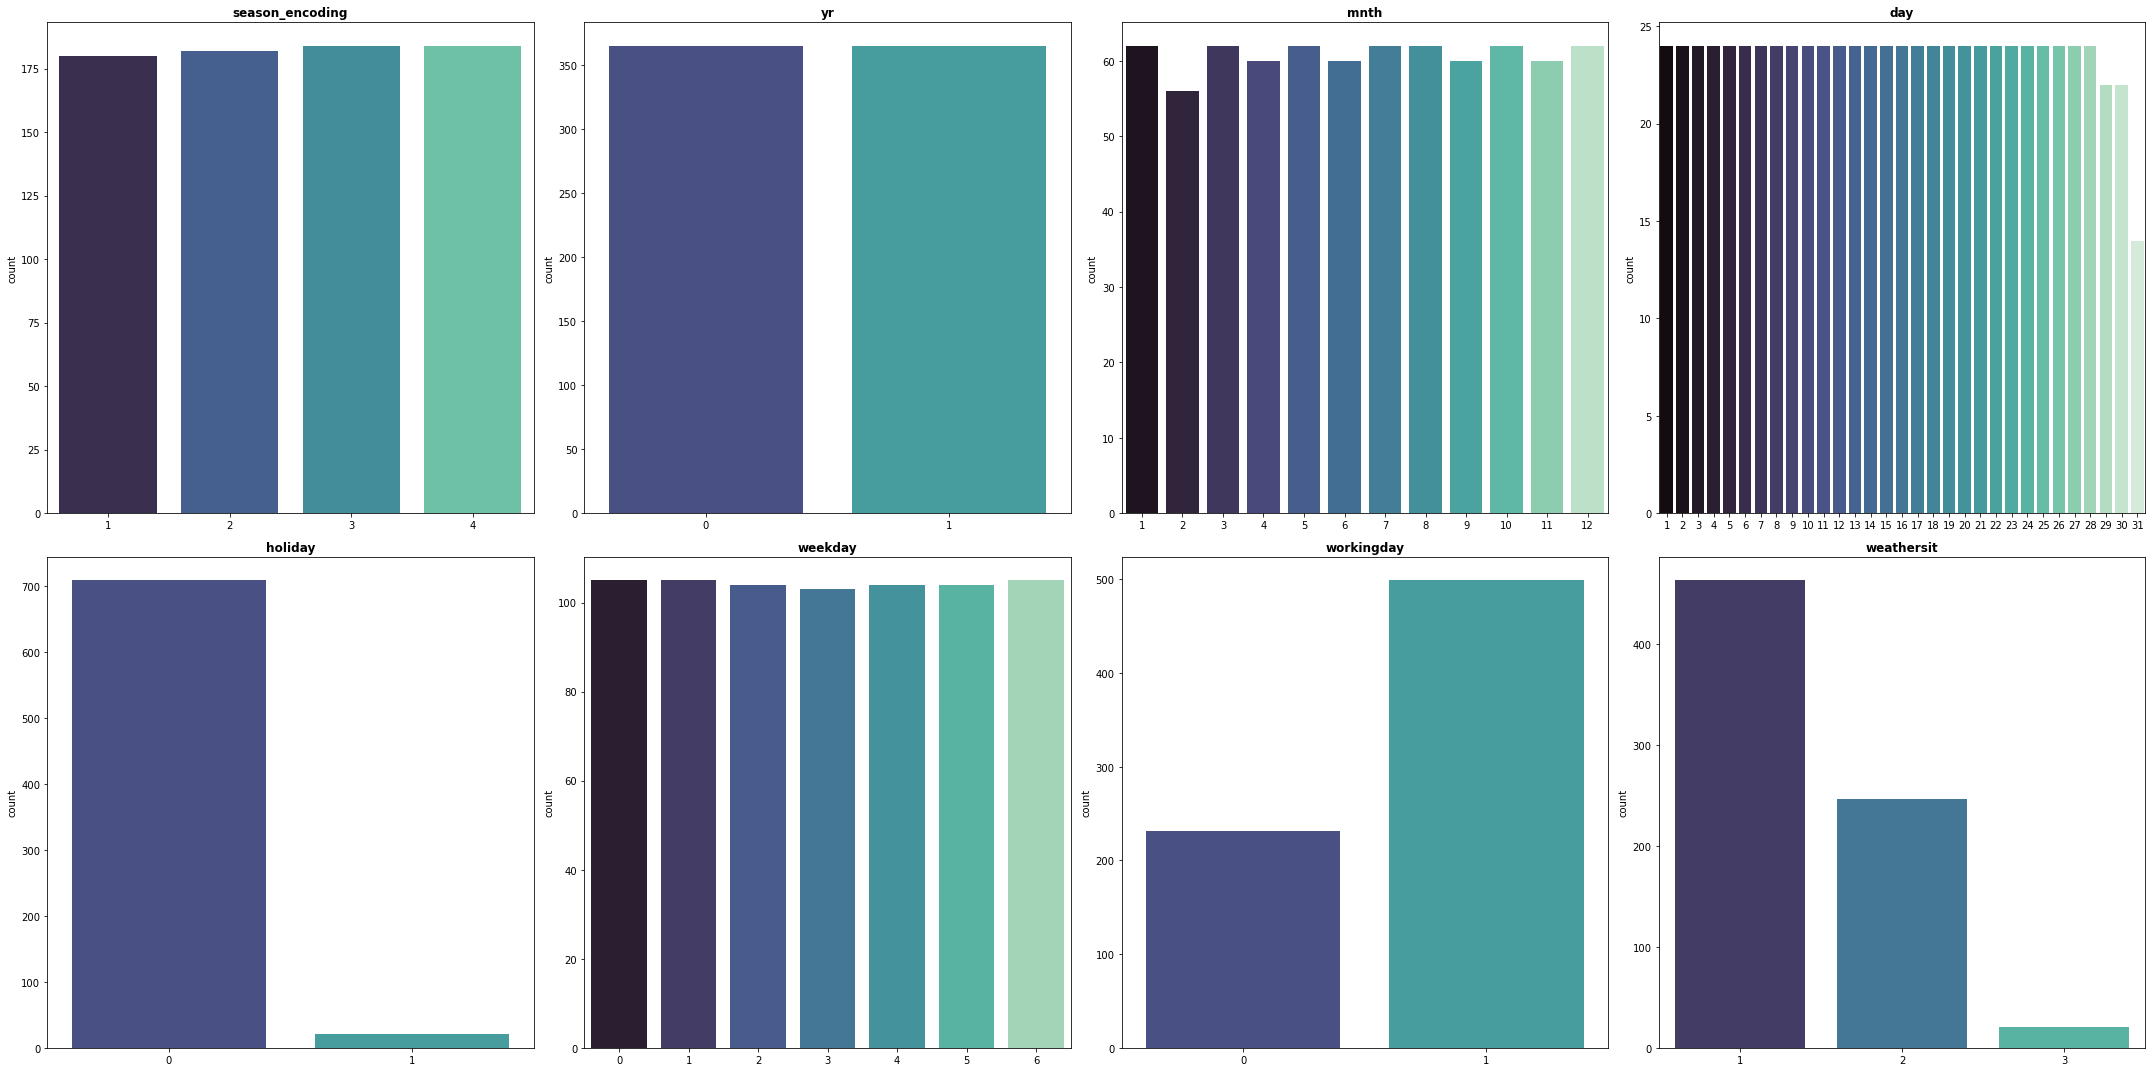

In [264]:
# Gráfico de relación entre variables predictoras y la variable a predecir CATEGORICAS
# ===================================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 15))

axes = axes.flat

columnas_object = df.select_dtypes(include = "category").columns

for i, colum in enumerate(columnas_object):
    sns.countplot(df[colum], ax=axes[i], palette="mako")
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig.tight_layout();



### Variables predictoras NUMERICAS - GRAFICO

    Estas son nuestras variables numéricas

In [265]:
numericas = df.select_dtypes(include = np.number)
numericas.head(1)

,casual,registered,cnt,temp,hum,windspeed
0,331,654,985,14.1,80.6,10.749882


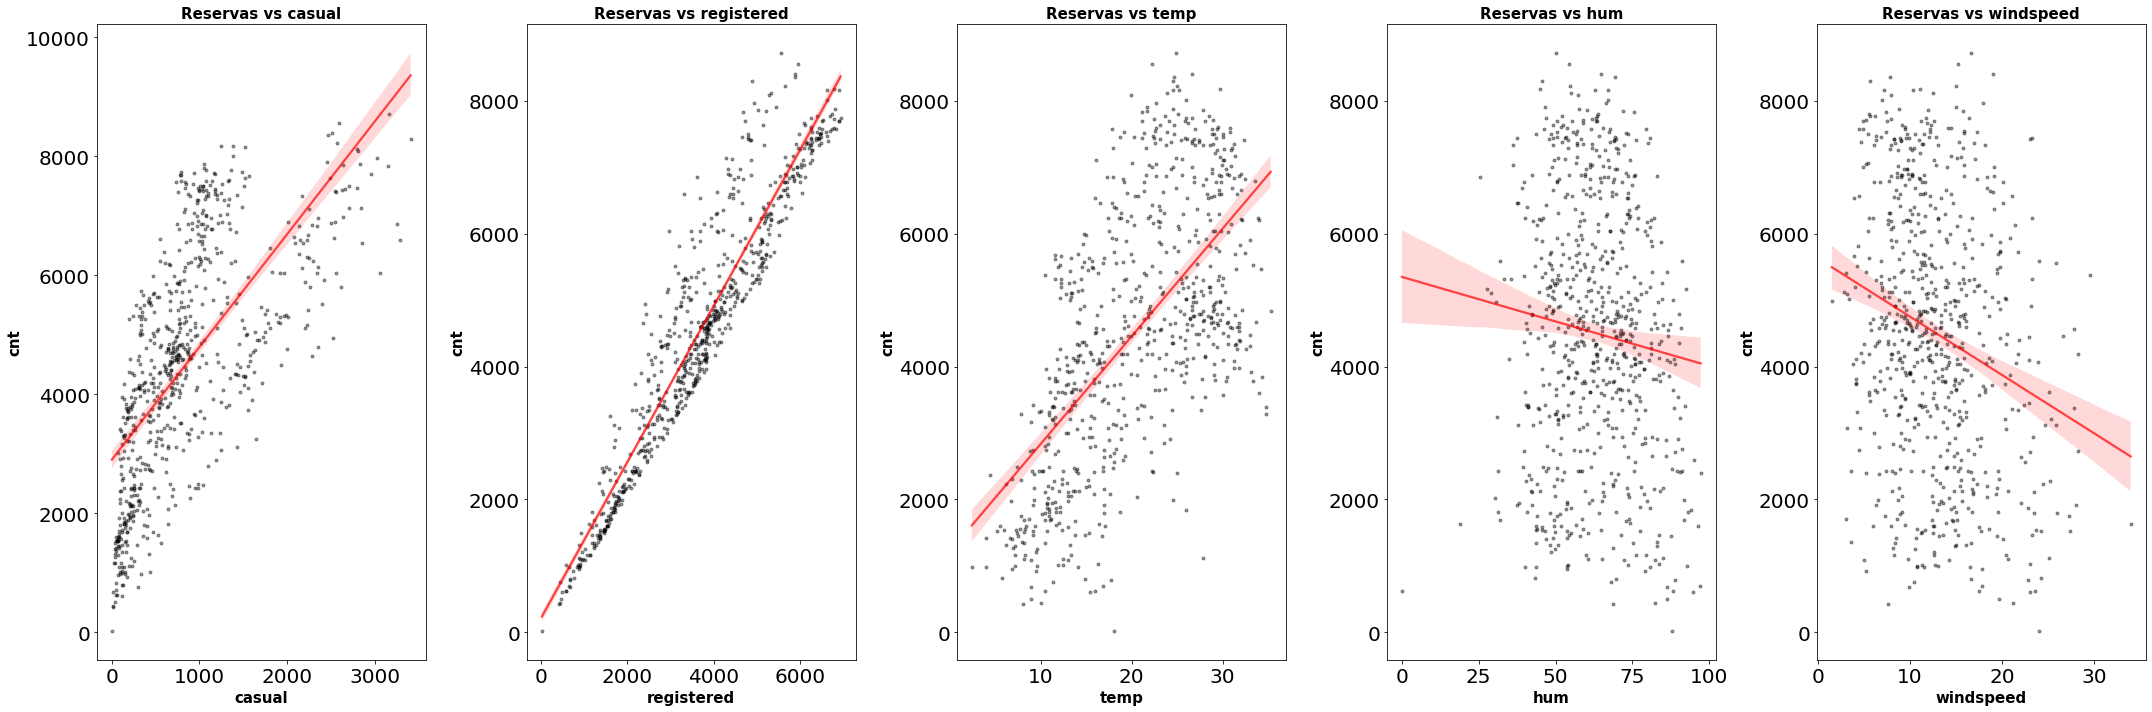

In [266]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (30, 10))

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("cnt") # excluimos nuestra variable respuesta. (No la necesitamos ahora

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["cnt"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Reservas vs {colum}", fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum,  fontsize = 15, fontweight = "bold")
    axes[i].set_ylabel("cnt", fontsize = 15, fontweight = "bold")
    
fig.tight_layout();

### Vamos a comprobar la relación entre todas las variables

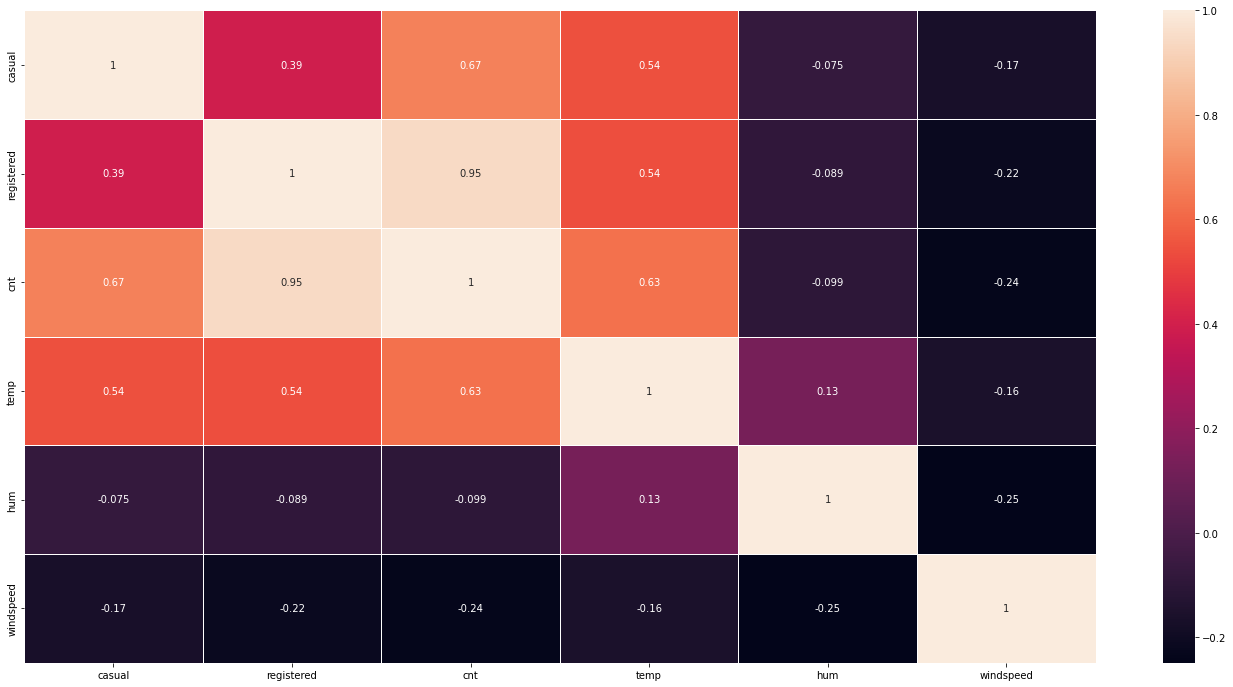

In [267]:
plt.figure(figsize = (24, 12))

corr = df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

    CORRELACIÓN
        Vamos a ver la correlación entre las variables predictoras y que relación tienen tb con la respuesta.
        intervalo [-1 y 1]
	    r= 1 corr perfecta positiva (aumenta una , la otra tb aumenta)
	    r =0 no hay correlación
 	    r= -1 corr perfecta negativa (una aumenta y la otra disminuye)

    Correlación con respecto a la columna "cnt"

In [268]:
correlation = df.corr()['cnt'].abs().sort_values(ascending = False) #correlación solo te enseña numéricas, Pearson RESPECTO A LA COLUMNA "cnt"
correlation

cnt           1.000000
registered    0.945411
casual        0.672123
temp          0.627003
windspeed     0.235132
hum           0.098502
Name: cnt, dtype: float64

    Correlación entre todas las numéricas

In [269]:
numericas.corr() 

,casual,registered,cnt,temp,hum,windspeed
casual,1.000000,0.394137,0.672123,0.542824,-0.075259,-0.167995
registered,0.394137,1.000000,0.945411,0.539345,-0.089140,-0.217914
cnt,0.672123,0.945411,1.000000,0.627003,-0.098502,-0.235132
temp,0.542824,0.539345,0.627003,1.000000,0.128716,-0.158367
hum,-0.075259,-0.089140,-0.098502,0.128716,1.000000,-0.248582
windspeed,-0.167995,-0.217914,-0.235132,-0.158367,-0.248582,1.000000


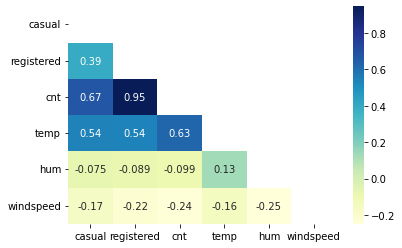

In [270]:
mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))
sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
           annot = True, 
           mask =mask);


### Vamos a comprobar la relación que hay entre numericas

In [271]:
numericas2 = df.select_dtypes(include = np.number).drop("cnt", axis = 1)

    COVARIANZA
    ¿Ambas variables aumentan o disminuyen en la misma dirección o cuando una aumenta la otra disminuye?
        S> 0 COVARIANZA POSITIVA : Todos aumentan misma dirección ( a grandes valores de X, grandes valores de Y)
        S = 0 NO HAY RELACIÓN LINEAL
        S< 0 COVARIANZA NEGATIVA: Aumenta una y disminuye la otra (a grandes valores de X , pequeños valores de Y)

In [272]:
numericas2.cov() # vamos a ver si existe colinealidad entre mas medias de las variables predictoras

,casual,registered,temp,hum,windspeed
casual,471254.618141,4.220196e+05,2797.280226,-735.582158,-599.212506
registered,422019.595513,2.432847e+06,6314.994264,-1979.593043,-1766.034199
temp,2797.280226,6.314994e+03,56.350559,13.757125,-6.176868
hum,-735.582158,-1.979593e+03,13.757125,202.717828,-18.389602
windspeed,-599.212506,-1.766034e+03,-6.176868,-18.389602,26.996761


----

### Comprobar Outliers en este modelo

In [273]:
def detectar_outliers(lista_columnas, dataframe): 
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    return dicc_indices 

In [274]:
lista_columnas = list(numericas.columns)
lista_columnas

['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

     Son pocos Outliers que no influyen en demasiado lo cambiamos por la mediana

In [275]:
ind = detectar_outliers(lista_columnas, df)
print(ind)

{'casual': [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679], 'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]}


In [276]:
for key, values in ind.items():
    median = df[key].median()
     
    if key == "hum" or key == 'windspeed':
        for i in values: 
            df.loc[i,key] = median
    else:
        pass

# Comprobación de las asunciones - Las variables predictoras deben cumplir: Homocedasteidad, Independencia 

### ASUNCIÓN DE NORMALIDAD  

    Ya la hemos comprobado y nuestros datos son normales.

- Visualmente
- Test de Shapiro


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

In [277]:
stats.shapiro(df["cnt"]) # El p-value< 0.05 Quiere decir que la distribución es normal

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

### ASUNCIÓN DE HOMOCEDASTICIDAD (Levene)

Las varianzas no difieren entre las distintas categorías de nuestros datos


| Test Levene  |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

    - Variables Categoricas -

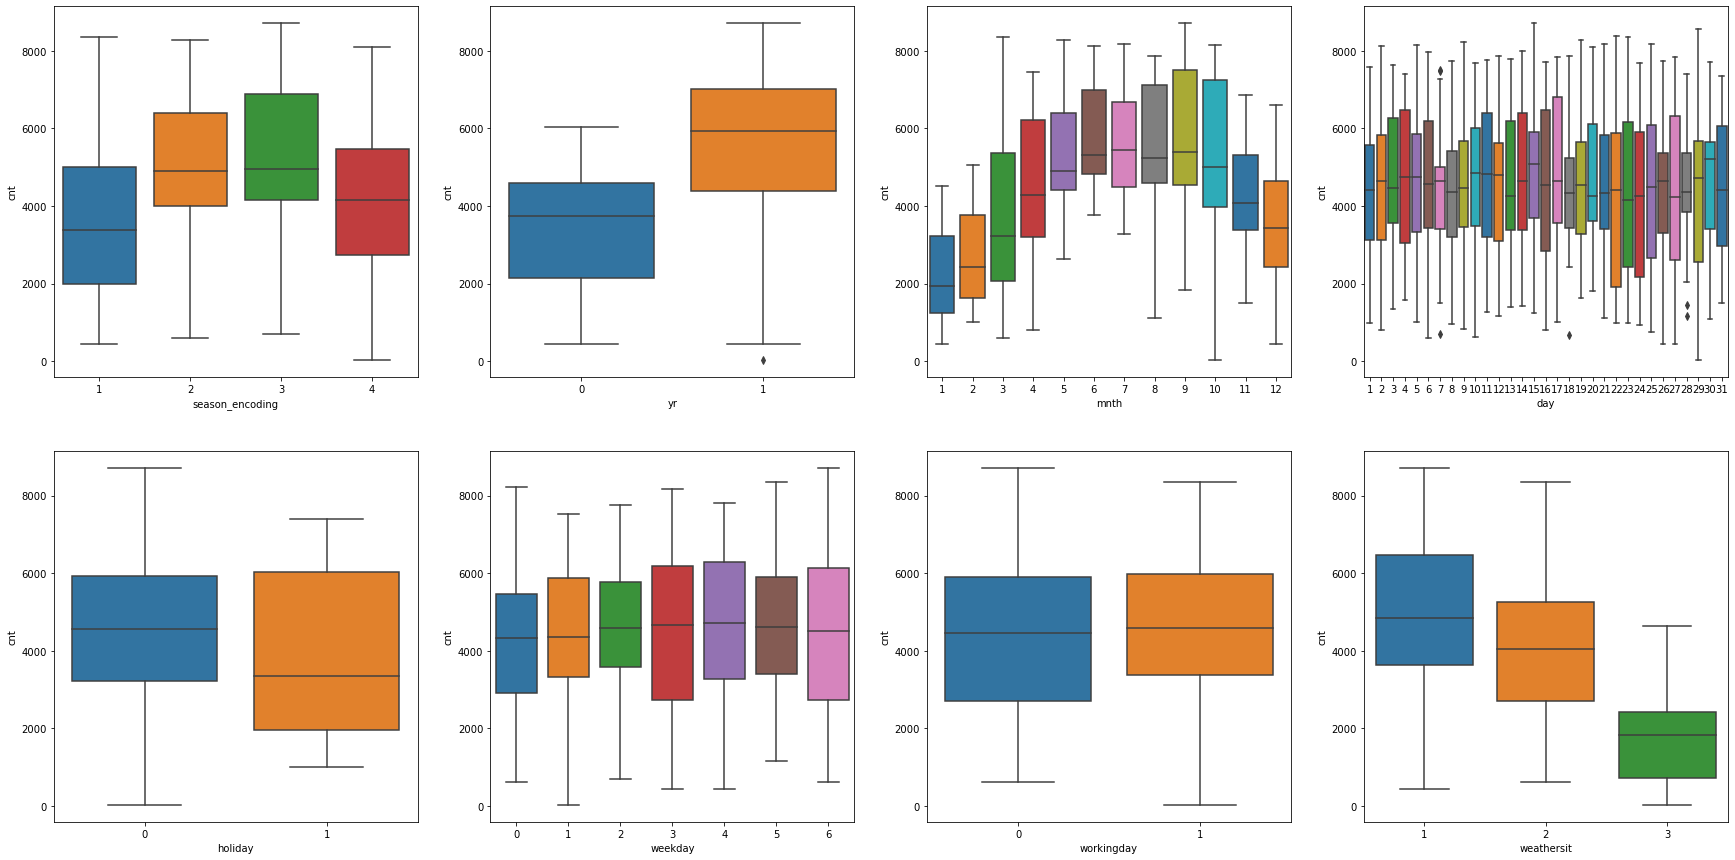

In [278]:
fig, axes = plt.subplots(nrows = 2, ncols = 4 ,figsize = (30, 15))

axes = axes.flat

colum_cat = df.select_dtypes(include = ['category']).columns

for i, col in enumerate(colum_cat):
    sns.boxplot(
        x = col,
        y = 'cnt',
        data = df,
        palette = 'tab10',
        ax = axes[i]

    )

                                                        --TEST LEVENE PARA CADA VARIABLE CATEGORICA PREDICTORA--

In [279]:
#Para desglosar cada una de las columnas, hacemos test de levene a cada una
def datos_test_levene (columna, df):
    valores = df[columna].unique()
    d = {}

    for x in valores:
        d['{0}'.format(x)] = df[df[columna] == x]['cnt']
    return d

In [280]:
# 8 variables categoricas predictoras
season = datos_test_levene('season_encoding', df)
year = datos_test_levene('yr', df)
month = datos_test_levene('mnth', df)
day = datos_test_levene('day', df)
holiday = datos_test_levene('holiday', df)
weekday =  datos_test_levene('weekday', df)
workingday = datos_test_levene('workingday', df)
weathersit = datos_test_levene('weathersit', df)

        --NO CUMPLEN--

In [281]:
levene_temp_interval = stats.levene(year['0'], year['1'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=13.553593496753745, pvalue=0.0002489869491449798)

In [282]:
levene_workingday = stats.levene(workingday['0'], workingday['1'], center='median')
levene_workingday # NO CUMPLE

LeveneResult(statistic=4.460702577469021, pvalue=0.03502326959654844)

In [283]:
levene_month = stats.levene(month['1'], month['2'],month['3'],month['4'],month['5'],month['6'],month['1'],month['7'],month['1'],month['8'],month['9'],month['10'],month['11'],month['12'], center='median')
levene_month # NO CUMPLE

LeveneResult(statistic=5.787944098760116, pvalue=2.73789175494516e-10)

    ---SI CUMPLE---

In [284]:
levene_season = stats.levene(season['1'], season['2'], season['3'], season['4'], center='median')
levene_season # SI CUMPLE

LeveneResult(statistic=1.7590626071065214, pvalue=0.15360584747469838)

In [285]:
levene_day = stats.levene(day['1'], day['2'],day['3'],day['4'],day['5'],day['6'],day['1'],day['7'],day['1'],day['8'],day['9'],day['10'],day['11'],day['12'],
 day['13'], day['14'],day['15'],day['16'],day['17'],day['18'],day['19'],day['20'],day['21'],day['22'],day['23'],day['24'],day['25'],day['26'],
 day['27'], day['28'],day['29'],day['30'],day['31'],center='median')
levene_day # SI CUMPLE

LeveneResult(statistic=0.5456780499569595, pvalue=0.9815493458112784)

In [286]:
levene_holiday = stats.levene(holiday['0'], holiday['1'], center='median')
levene_holiday # SI CUMPLE

LeveneResult(statistic=0.7261499110317795, pvalue=0.39441424379573353)

In [287]:
levene_weekday = stats.levene(weekday['0'], weekday['1'],weekday['2'],weekday['3'],weekday['4'],weekday['5'],weekday['6'], center='median')
levene_weekday # SI CUMPLE

LeveneResult(statistic=1.496581827336433, pvalue=0.17647662349169893)

In [288]:
levene_weathersit = stats.levene(weathersit['1'], weathersit['2'], weathersit['3'],center='median')
levene_weathersit # SI CUMPLE

LeveneResult(statistic=2.981948873358019, pvalue=0.05131438057388725)

    Numéricas

In [289]:

# creamos un diccionario para almacenar los resultados de los test
resultados = {}

# seleccionamos solo las columnas numéricas y eliminamos la columna de precio
numericas_col = df.select_dtypes(include = np.number).drop("cnt", axis = 1).columns

#iteremos por la lista de las columnas numéricas
for col in numericas_col:
    # calculamos el p-valor de test
    statistic, p_val = levene(df[col], df.cnt, center='median')
    # lo almacenamos en el charges
    resultados[col] = p_val

                    --  NO CUMPLEN NINGUNA --

In [290]:
resultados 

{'casual': 3.031094721085453e-106,
 'registered': 3.756413456870291e-09,
 'temp': 2.483823693494982e-220,
 'hum': 2.4852444623529654e-219,
 'windspeed': 6.996761844872213e-221}

    Aplicamos log a las variables numéricas, para ver si podemos transformar y que alguna o todas puedan cumplir la asunción.  NO IMPLICA CAMBIO

In [291]:
#hemos intentado hacer logaritmonimos las variables categoricas .    NO nos funciona.

# df['casual'] = df['casual'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['registered'] = df['registered'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['temp'] = df['temp'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['hum'] = df['hum'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['windspeed'] = df['windspeed'].apply(lambda x: np.log(x) if x != 0 else 0)

    Aplicamos raiz cuadrada a las variables numéricas, para ver si podemos transformar y que alguna o todas puedan cumplir la asunción.

In [292]:
df["temp"]= df["temp"].apply(lambda x: math.sqrt(x))
df["hum"]= df["hum"].apply(lambda x: math.sqrt(x))
df["windspeed"]= df["windspeed"].apply(lambda x: math.sqrt(x))

In [293]:

# creamos un diccionario para almacenar los resultados de los test
resultados2 = {}

# seleccionamos solo las columnas numéricas y eliminamos la columna de precio
numericas_col = df.select_dtypes(include = np.number).drop(["cnt","casual","registered"],  axis = 1).columns

#iteremos por la lista de las columnas numéricas
for col in numericas_col:
    # calculamos el p-valor de test
    statistic, p_val = levene(df[col], df.cnt, center='median')
    # lo almacenamos en el charges
    resultados2[col] = p_val

    Hemos conseguido que "temp" cumpla la asunción de homocedasticidad. con raiz cuadrada.

In [294]:
resultados2

{'temp': 1.7132139764806943e-221,
 'hum': 1.700040354507953e-221,
 'windspeed': 1.5614947187968603e-221}

In [295]:
df.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,331,654,985,1,0,1,1,0,6,0,2,3.754997,8.977750,3.278701
1,131,670,801,1,0,1,2,0,0,0,2,3.860052,8.342661,4.080700
2,120,1229,1349,1,0,1,3,0,1,1,1,2.846050,6.610598,4.078811
3,108,1454,1562,2,0,1,4,0,2,1,1,2.863564,7.681146,3.277168
4,82,1518,1600,2,0,1,5,0,3,1,1,3.049590,6.610598,3.538686


## Asunción independencia (Chi-Cuadrado)


| Test Independencia |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [296]:
columnas = df.columns

In [297]:
combinaciones = list(itertools.combinations(columnas, 2))
combinaciones[13]

('registered', 'cnt')

In [298]:
combinaciones = list(itertools.combinations(columnas, 2))
combinaciones_cnt= combinaciones[25:36]#, combinaciones[1], combinaciones[13] # ya solo te muestra con respecto a "cnt"
combinaciones_cnt

[('cnt', 'season_encoding'),
 ('cnt', 'yr'),
 ('cnt', 'mnth'),
 ('cnt', 'day'),
 ('cnt', 'holiday'),
 ('cnt', 'weekday'),
 ('cnt', 'workingday'),
 ('cnt', 'weathersit'),
 ('cnt', 'temp'),
 ('cnt', 'hum'),
 ('cnt', 'windspeed')]

    Test Chi Cuadrado
    Kramer: 
    de 0-0,1: no hay independencia
    de 0,1 - 0,3 independencia baja
    0,3 a 0,5 independencia moderada
    0,5+ independencia alta


In [299]:
for par in combinaciones_cnt:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    print("---------------------------------", par[0], par[1], "---------------------------------")
    print(test_results) #todas son independientes

--------------------------------- cnt season_encoding ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 2082.0) =   2089.9375
1                       p-value =      0.4470
2                    Cramer's V =      0.9769
--------------------------------- cnt yr ---------------------------------
                  Chi-square test   results
0  Pearson Chi-square ( 694.0) =   706.0000
1                      p-value =     0.3676
2                   Cramer's V =     0.9834
--------------------------------- cnt mnth ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 7634.0) =   7636.3074
1                       p-value =      0.4904
2                    Cramer's V =      0.9752
--------------------------------- cnt day ---------------------------------
                    Chi-square test     results
0  Pearson Chi-square ( 20820.0) =   20849.4399
1                        p-value =       0.4

--Si son independientes--

# ANOVA

    Ya podemos pasar a la ANOVA después de comprobar si las variables predictoras cumplen las asunciones

In [300]:
df.columns

Index(['casual', 'registered', 'cnt', 'season_encoding', 'yr', 'mnth', 'day',
       'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum',
       'windspeed'],
      dtype='object')

    TEner en cuenta que no está registred!!! Cambia mucho

In [301]:
lm = ols('cnt ~ casual + season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp + hum +  windspeed' , data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
season_encoding,3.0,2.965983e+08,9.886610e+07,266.147810,9.321598e-114
yr,1.0,8.869095e+08,8.869095e+08,2387.562743,3.283500e-223
mnth,11.0,7.803896e+08,7.094451e+07,190.982814,2.761071e-198
day,30.0,6.263900e+07,2.087967e+06,5.620812,1.604134e-18
holiday,1.0,8.356054e+06,8.356054e+06,22.494520,2.575652e-06
weekday,6.0,1.555021e+07,2.591702e+06,6.976869,3.276327e-07
workingday,1.0,1.100045e+06,1.100045e+06,2.961324,8.573907e-02
weathersit,2.0,1.740145e+08,8.700727e+07,234.223816,6.989472e-78
casual,1.0,2.338266e+08,2.338266e+08,629.461801,1.701989e-98
temp,1.0,1.582839e+07,1.582839e+07,42.610081,1.318290e-10


In [302]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     115.3
Date:                Tue, 14 Jun 2022   Prob (F-statistic):          5.03e-309
Time:                        12:55:51   Log-Likelihood:                -5686.3
No. Observations:                 730   AIC:                         1.149e+04
Df Residuals:                     671   BIC:                         1.176e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              126.8189    384.612      0.330      0.742    -628.368     882.006
season_encoding[T.2]   -84.9426    131.929     -0.644      0.520    -343.985     174.100
season_encoding[T.3]   170.5716    134.709      1.266      0.206     -93.930     435.073
season_encoding[T.4]  -833.6048    133.454     -6.246      0.000   -1095.643    -571.566
yr[T.1]               1615.7609     50.049     32.284      0.000    1517.490    1714.032
mnth[T.2]              112.1146    116.039      0.966      0.334    -115.729     339.958
mnth[T.3]              266.8824    126.547      2.109      0.035      18.407     515.358
mnth[T.4]              596.7655    166.348      3.587      0.000     270.140     923.391
mnth[T.5]              854.3426    185.257      4.612      0.000     490.590    1218.095
mnth[T.6]              896.4436    203.824      4.398      0.000     496.235    1296.652
mnth[T.7]              433.4611    227.640      1.904      0.057     -13.511     880.433
mnth[T.8]              698.5481    217.510      3.212      0.001     271.465    1125.631
mnth[T.9]             1234.8895    199.984      6.175      0.000     842.220    1627.559
mnth[T.10]            1874.4981    173.690     10.792      0.000    1533.457    2215.540
mnth[T.11]            1578.8748    152.651     10.343      0.000    1279.143    1878.607
mnth[T.12]            1296.1211    145.592      8.902      0.000    1010.250    1581.993
day[T.2]                65.3309    176.666      0.370      0.712    -281.553     412.215
day[T.3]               100.8838    177.052      0.570      0.569    -246.760     448.527
day[T.4]               190.6940    221.673      0.860      0.390    -244.562     625.950
day[T.5]               205.6736    220.718      0.932      0.352    -227.708     639.055
day[T.6]               236.3042    221.213      1.068      0.286    -198.049     670.658
day[T.7]              -199.0827    222.663     -0.894      0.372    -636.282     238.117
day[T.8]              -154.8477    222.122     -0.697      0.486    -590.986     281.290
day[T.9]               -96.7100    221.572     -0.436      0.663    -531.767     338.347
day[T.10]             1021.3557    221.743      4.606      0.000     585.961    1456.750
day[T.11]             1096.2093    221.314      4.953      0.000     661.657    1530.761
day[T.12]             1032.6212    221.733      4.657      0.000     597.246    1467.996
day[T.13]              283.3063    195.552      1.449      0.148    -100.661     667.274
day[T.14]              253.1353    194.983      1.298      0.195    -129.716     635.986
day[T.15]              426.1484    195.642      2.178      0.030      42.004     810.293
day[T.16]              473.7662    195.690      2.421      0.016      89.527     858.005
day[T.17]              477.4238    195.955      2.436    

# VIF - Para comprobar si hay o no multicolinealidad (Correlación alta entre dos v. predictoras), podemos averiguar si eliminar o no ésta variable.

Vif = 1 No existe corr entre una variable predictora y el resto

Vif = 1-5 Correlación moderada

Vif= +5 Correlación severa (Puede que se deba eliminar esa variable)

In [303]:
def get_VIF(dataframe, target):
        X = add_constant(dataframe.loc[:, dataframe.columns != target])
        seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,).sort_values(ascending= False)
        return seriesObject

In [304]:
get_VIF(df,'cnt')

const              185.837978
registered           5.400016
casual               3.581138
workingday           3.052780
temp                 2.732621
yr                   2.549552
hum                  2.005388
mnth                 1.976458
weathersit           1.945496
season_encoding      1.608126
windspeed            1.198381
holiday              1.097866
day                  1.053915
weekday              1.042269
dtype: float64

In [305]:
get_VIF(df.drop(columns=['registered','casual']),'cnt')

const              185.092596
hum                  1.969650
weathersit           1.794564
mnth                 1.736265
season_encoding      1.602056
temp                 1.159508
windspeed            1.146359
holiday              1.081026
workingday           1.076593
day                  1.048698
yr                   1.027721
weekday              1.018609
dtype: float64

# Regresion Lineal

    Prueba con los datos tal cualen DF

In [306]:
# df.head(2)

In [307]:
# lo primero que hacemos es definir cual es nuestra variable Y y nuestras variables X
# X = df.drop(['cnt', 'registered','casual'],axis =1)
# y = df['cnt']

In [308]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred_train = lr.predict(X_train)
# y_pred_test = lr.predict(X_test)

In [309]:
# def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
#     resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
#                 'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
#                 'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
#                 'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
#                  "set": ["test", "train"]}
#     df = pd.DataFrame(resultados)
#     return df
    

In [310]:
# results = metricas(y_test, y_train, y_pred_test, y_pred_train)
# results.style.background_gradient(cmap='coolwarm')
# results

    Prueba Estandarizando las variables numéricas

In [311]:
df_standardized = df.copy()

In [312]:
numericas2 = df_standardized.select_dtypes(include = np.number)

In [313]:
st = MinMaxScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(numericas2))
x_tranformadas.columns = numericas2.columns
df[x_tranformadas.columns] = x_tranformadas
df.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,0.096538,0.091539,0.110792,1,0,1,1,0,6,0,2,0.502211,0.817135,0.539301
1,0.037852,0.093849,0.089623,1,0,1,2,0,0,0,2,0.526129,0.685351,0.749889
2,0.034624,0.174560,0.152669,1,0,1,3,0,1,1,1,0.295264,0.325940,0.749394
3,0.031103,0.207046,0.177174,2,0,1,4,0,2,1,1,0.299252,0.548083,0.538898
4,0.023474,0.216286,0.181546,2,0,1,5,0,3,1,1,0.341606,0.325940,0.607568


In [314]:
x2 = df_standardized.drop(['cnt','registered','casual'] ,axis =1)
y2 = df_standardized['cnt']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, train_size   = 0.8, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [316]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

In [317]:
results = metricas(y_test, y_train, y_pred_test, y_pred_train)
results.style.background_gradient(cmap='coolwarm')
results

,MAE,MSE,RMSE,R2,set
0,603.092872,623348.426291,789.524177,0.817886,test
1,692.619303,832148.058737,912.221497,0.781914,train


----

    Residuos son valores reales frente a los predichos: valor real menos valor predicho

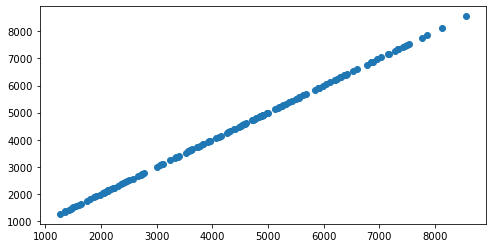

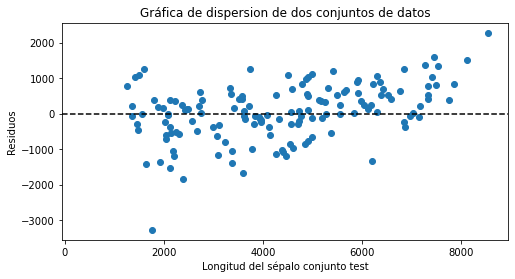

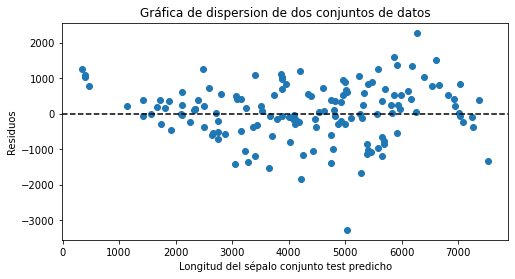

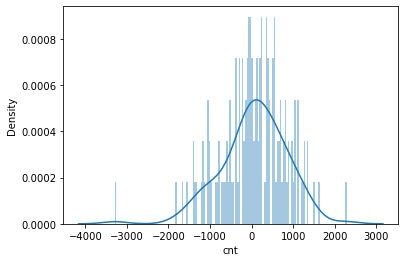

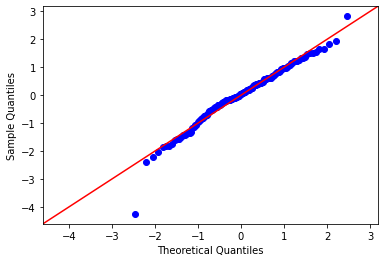

In [318]:
# Aquí comienza la resolucion del ejercicio 1
residuals = (y_test - y_pred_test)

# 1. Linealidad

plt.figure(figsize =(8,4))
plt.scatter(x=y_test , y=y_test)
plt.show()

# 2. Independencia

fig,ax = plt.subplots(figsize= (8,4))
plt.scatter(x=y_test , y=residuals)
plt.axline((float(min(y_pred_test)),0),(float(max(y_pred_test)),0),color="black",linestyle= '--') 
plt.title('Gráfica de dispersion de dos conjuntos de datos')
ax.set_xlabel('Longitud del sépalo conjunto test')
ax.set_ylabel('Residuos')
plt.show()

# 3. Homocedasticidad

fig,ax = plt.subplots(figsize= (8,4))
plt.scatter(x=y_pred_test , y=residuals)
plt.axline((float(min(y_pred_test)),0),(float(max(y_pred_test)),0),color="black",linestyle= '--') 
plt.title('Gráfica de dispersion de dos conjuntos de datos')
ax.set_xlabel('Longitud del sépalo conjunto test predicho')
ax.set_ylabel('Residuos')
plt.show()

# 4. Normalidad
# preprocessing.normalize()
fig = plt.figure()
sns.distplot(residuals,bins = len(residuals))
plt.show()
sm.qqplot(residuals, line = '45', fit = True)
py.show()

-----

    Probar predicción

In [323]:
df_standardized.head()

,casual,registered,cnt,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,331,654,985,1,0,1,1,0,6,0,2,3.754997,8.977750,3.278701
1,131,670,801,1,0,1,2,0,0,0,2,3.860052,8.342661,4.080700
2,120,1229,1349,1,0,1,3,0,1,1,1,2.846050,6.610598,4.078811
3,108,1454,1562,2,0,1,4,0,2,1,1,2.863564,7.681146,3.277168
4,82,1518,1600,2,0,1,5,0,3,1,1,3.049590,6.610598,3.538686


In [324]:
dict_model = {"season_encoding":[2] ,'yr':[2], 'mnth':[7], 'day':[14] , 'holiday':[0], 'weekday':[4], 'workingday':[1], 'weathersit':[1], 'temp':[38], 'hum':[30], 'windspeed':[10]}
df_dict_model = pd.DataFrame(dict_model)

    ¿Cuantas reservas de bicicletas habrá en season: , , el 14 de Julio , bla bla?

In [325]:
lr.predict(df_dict_model) #número de bicicletas que serán reservadas

array([44047.22373029])